# Computer Vision project 3 - final report

Team members: Joanna Działo 148260, Wojciech Majewski 148253

Selected problem: Colourization -
We will attempt to accurately colour greyscale images using Neural Networks.

Dataset: https://paperswithcode.com/dataset/spair-71k

### Problem description

The goal of this project is to accurately predict the original colors of a greyscale image. Our dataset contains colored images, from which we generate their greyscale counterparts. 

### Dataset description

The dataset consists of 18 categories with 100 photos each.

#### Downloading dataset

In [1]:
import os
import numpy as np
import cv2
if 'google.colab' in str(get_ipython()):
  from google.colab.patches import cv2_imshow
  imshow = cv2_imshow
else:
  imshow = cv2.imshow

In [2]:
!wget -O SPair-71k.tar.gz http://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz

--2023-01-25 23:42:17--  http://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz
Resolving cvlab.postech.ac.kr (cvlab.postech.ac.kr)... 141.223.85.126
Connecting to cvlab.postech.ac.kr (cvlab.postech.ac.kr)|141.223.85.126|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226961117 (216M) [application/x-gzip]
Saving to: ‘SPair-71k.tar.gz’

SPair-71k.tar.gz    100%[===================>] 216.45M  36.1MB/s    in 6.5s    

2023-01-25 23:42:24 (33.3 MB/s) - ‘SPair-71k.tar.gz’ saved [226961117/226961117]



In [3]:
!mkdir dataset

In [4]:
!tar -xzf SPair-71k.tar.gz -C dataset

In [5]:
!mv dataset/SPair-71k/JPEGImages /content/

!rm -rf SPair-71k.tar.gz
!rm -rf dataset

In [6]:
!mv JPEGImages dataset

#### Dataset categories names and sizes

In [7]:
categories = os.listdir("dataset")
print(categories)

['bicycle', 'tvmonitor', 'person', 'chair', 'dog', 'boat', 'bottle', 'aeroplane', 'train', 'motorbike', 'pottedplant', 'cow', 'cat', 'horse', 'bus', 'car', 'bird', 'sheep']


In [8]:
sizes = [len([os.path.join(os.path.join('dataset', cat), img) for img in os.listdir(os.path.join('dataset', cat))]) for cat in categories]
print(sizes)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


#### Dataset image examples

In [9]:
def load_images(path, category, limit = None):
    category_path = os.path.join(path, category)
    images_paths = [os.path.join(category_path,img) for img in os.listdir(category_path)]
    images = [cv2.resize(cv2.imread(f, 1), (256, 256)) for f in images_paths]
    if limit == None:
        return images
    else:
        limit_norm = min(limit, len(images))
        return images[:limit_norm]
        
def create_dataset(path, categories = None, limit = None):
    if categories == None:
        categories = os.listdir(path)
    y = []
    for category in categories:
        images = load_images(path, category, limit)
        y.extend(images)
    return y

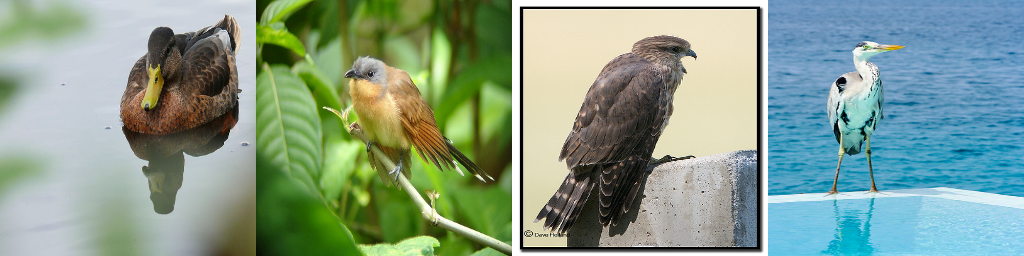

In [10]:
images = load_images("dataset", "bird")
imshow(np.concatenate((images[:4]), 1))

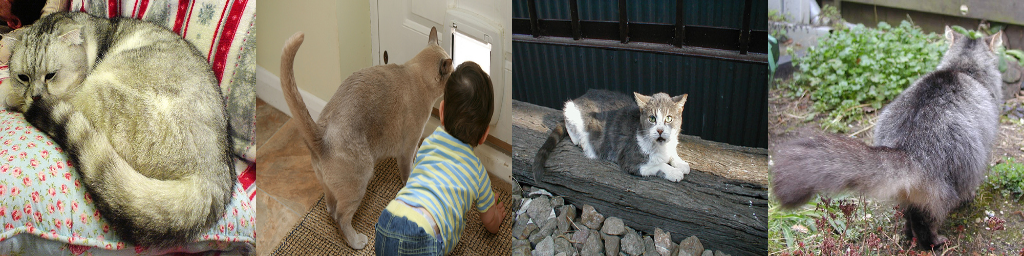

In [11]:
images = load_images("dataset", "cat")
imshow(np.concatenate((images[:4]), 1))

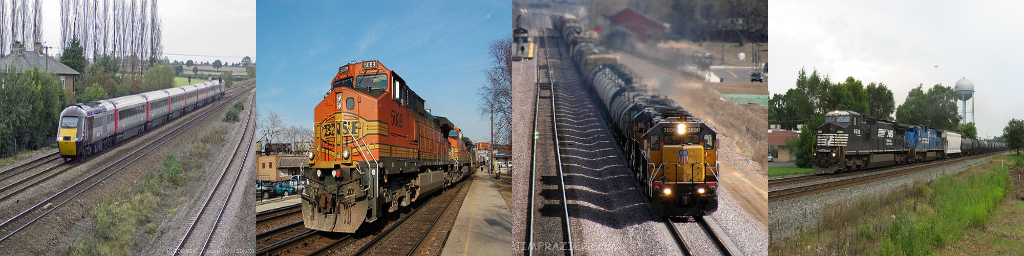

In [12]:
images = load_images("dataset", "train")
imshow(np.concatenate((images[:4]), 1))

#### Notably, there are some 'black sheep' in our dataset:

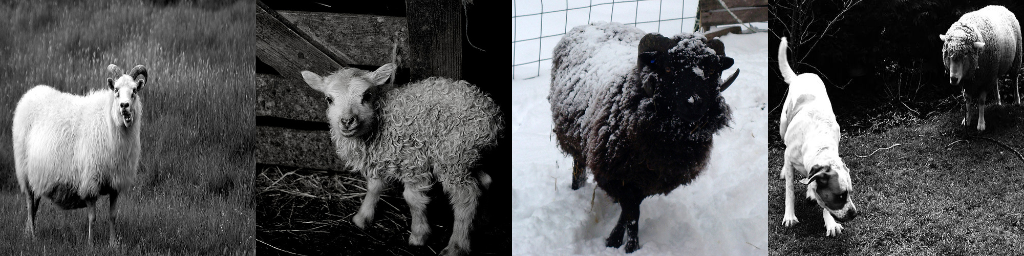

In [13]:
images = load_images("dataset", "sheep")
imshow(np.concatenate((images[95], images[12], images[22], images[66]), 1))

In [14]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten, MaxPool2D, Reshape
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from math import floor
from tensorflow.keras.utils import img_to_array

In [15]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Dividing data into train, validation and test datasets

In [16]:
def create_split_dataset_3(path, categories = None, training_split = 0.8, test_split = 0.1, size = 256):
    if categories == None:
        categories = os.listdir(path)
    
    X_train = []
    y_train = []
    X_validation = []
    y_validation = []
    X_test = []
    y_test = []


    for category in categories:

        color_images = []
        gray_images = []
        category_path = os.path.join(path, category)

        images_paths = [os.path.join(category_path,img) for img in os.listdir(category_path)]

        i = 0
        for image_path in images_paths:
            image = cv2.cvtColor(cv2.cvtColor(cv2.imread(image_path, 1), cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
            image = cv2.resize(image, (size, size), cv2.INTER_CUBIC)
            image = image.astype('float32')/255.0
            gray_images.append(img_to_array(image))
            image = cv2.cvtColor(cv2.imread(image_path, 1), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (size, size), cv2.INTER_CUBIC)
            image = image.astype('float32')/255.0
            color_images.append(img_to_array(image))
        
        y_train += color_images[:floor(len(color_images) * training_split)]
        X_train += gray_images[:floor(len(color_images) * training_split)]
        y_validation += color_images[floor(len(color_images) * training_split) : floor(len(color_images) * (test_split + training_split))]
        X_validation += gray_images[floor(len(color_images) * training_split) : floor(len(color_images) * (test_split + training_split))]
        y_test += color_images[floor(len(color_images) * (test_split + training_split)):]
        X_test += gray_images[floor(len(color_images) * (test_split + training_split)):]


    X_train = np.reshape(X_train, (len(X_train), size, size, 3))
    y_train = np.reshape(y_train, (len(y_train), size, size, 3))
    X_validation = np.reshape(X_validation, (len(X_validation), size, size, 3))
    y_validation = np.reshape(y_validation, (len(y_validation), size, size, 3))
    X_test = np.reshape(X_test, (len(X_test), size, size, 3))
    y_test = np.reshape(y_test, (len(y_test), size, size, 3))

    print(X_train.shape)
    print(y_train.shape)
    print(X_validation.shape)
    print(y_validation.shape)
    print(X_test.shape)
    print(y_test.shape)

    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [17]:
X_train, y_train, X_validation, y_validation, X_test, y_test = create_split_dataset_3('dataset', size = 200)

(1440, 200, 200, 3)
(1440, 200, 200, 3)
(180, 200, 200, 3)
(180, 200, 200, 3)
(180, 200, 200, 3)
(180, 200, 200, 3)


### Model description

In [28]:
encoder = Sequential([
      InputLayer(input_shape=(200, 200, 3),name="Input_layer"),
      BatchNormalization(),
      Conv2D(64,kernel_size=3,padding='same',activation='relu',kernel_initializer='lecun_normal',name="Conv_01"),
      BatchNormalization(),
      MaxPool2D(),
      Conv2D(128,kernel_size=3,padding='same',activation='relu',kernel_initializer='lecun_normal',name="Conv_02"),
      BatchNormalization(),
      MaxPool2D(),
      Conv2D(256,kernel_size=3,padding='same',activation='relu',kernel_initializer='lecun_normal',name="Conv_03"),
      BatchNormalization(),
      MaxPool2D(),
      Conv2D(512,kernel_size=3,padding='same',activation='relu',kernel_initializer='lecun_normal',name="Conv_04"),
      BatchNormalization(),
      MaxPool2D(),
  ])

decoder = Sequential([
      InputLayer(input_shape=(encoder.output_shape[-3:]),name='decoder_input'),
      BatchNormalization(),
      Conv2DTranspose(256,kernel_size=3,strides=2,padding='valid',activation='relu',kernel_initializer='lecun_normal',name='ConvT_01'),
      BatchNormalization(),
      Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',activation='relu',kernel_initializer='lecun_normal',name='ConvT_02'),
      BatchNormalization(),
      Conv2DTranspose(64,kernel_size=3,strides=2,padding='same',activation='relu',kernel_initializer='lecun_normal',name='ConvT_03'),
      BatchNormalization(),
      Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',activation='relu',kernel_initializer='glorot_normal',name='ConvT_04'),
      Reshape([200, 200, 3])
  ])

autoencoder = Sequential([encoder, decoder])
autoencoder.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.MeanSquaredError()]
    )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Batc  (None, 200, 200, 3)      12        
 hNormalization)                                                 
                                                                 
 Conv_01 (Conv2D)            (None, 200, 200, 64)      1792      
                                                                 
 batch_normalization_10 (Bat  (None, 200, 200, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 64)     0         
 2D)                                                             
                                                                 
 Conv_02 (Conv2D)            (None, 100, 100, 128)     73856     
                                                      

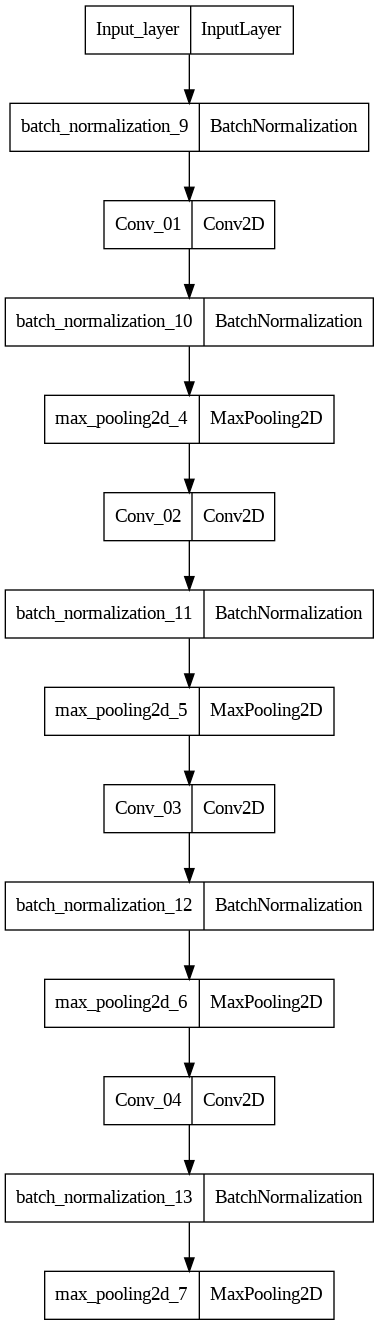

In [29]:
encoder.summary()
tf.keras.utils.plot_model(encoder)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_14 (Bat  (None, 12, 12, 512)      2048      
 chNormalization)                                                
                                                                 
 ConvT_01 (Conv2DTranspose)  (None, 25, 25, 256)       1179904   
                                                                 
 batch_normalization_15 (Bat  (None, 25, 25, 256)      1024      
 chNormalization)                                                
                                                                 
 ConvT_02 (Conv2DTranspose)  (None, 50, 50, 128)       295040    
                                                                 
 batch_normalization_16 (Bat  (None, 50, 50, 128)      512       
 chNormalization)                                                
                                                      

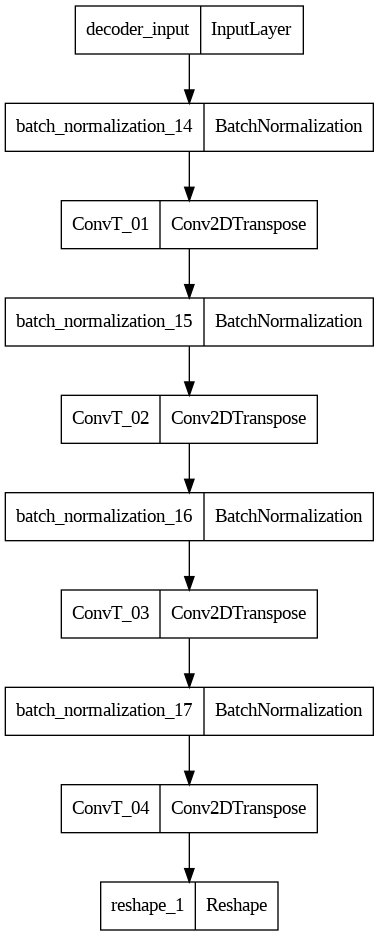

In [30]:
decoder.summary()
tf.keras.utils.plot_model(decoder)

### Training the model

In [31]:
history = autoencoder.fit(
    X_train, 
    y_train, 
    batch_size=32, 
    epochs=250, 
    validation_data=(X_validation, y_validation)
)

Epoch 1/250
45/45 [==============================] - 17s 346ms/step - loss: 0.0346 - accuracy: 0.3972 - mean_squared_error: 0.0696 - val_loss: 0.0681 - val_accuracy: 0.3704 - val_mean_squared_error: 0.1361
Epoch 2/250
45/45 [==============================] - 15s 335ms/step - loss: 0.0128 - accuracy: 0.4250 - mean_squared_error: 0.0255 - val_loss: 0.0263 - val_accuracy: 0.4001 - val_mean_squared_error: 0.0526
Epoch 3/250
45/45 [==============================] - 15s 332ms/step - loss: 0.0109 - accuracy: 0.4285 - mean_squared_error: 0.0219 - val_loss: 0.0239 - val_accuracy: 0.4125 - val_mean_squared_error: 0.0478
Epoch 4/250
45/45 [==============================] - 15s 330ms/step - loss: 0.0104 - accuracy: 0.4322 - mean_squared_error: 0.0207 - val_loss: 0.0178 - val_accuracy: 0.4548 - val_mean_squared_error: 0.0356
Epoch 5/250
45/45 [==============================] - 15s 330ms/step - loss: 0.0104 - accuracy: 0.4406 - mean_squared_error: 0.0208 - val_loss: 0.0131 - val_accuracy: 0.4318 - v

### Training plots

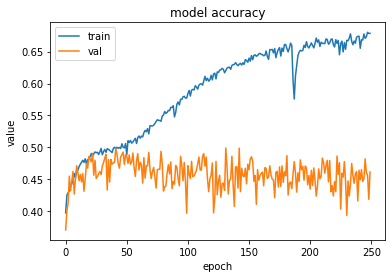

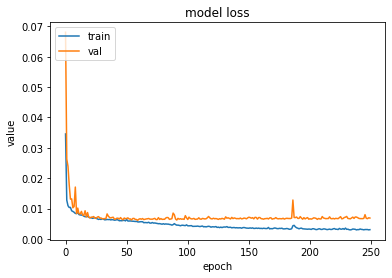

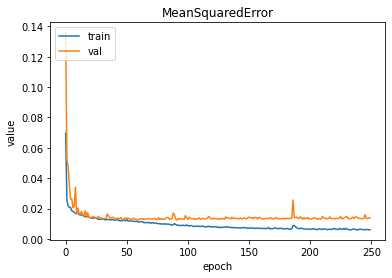

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MeanSquaredError')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Results

1/1 [==============================] - 1s 552ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


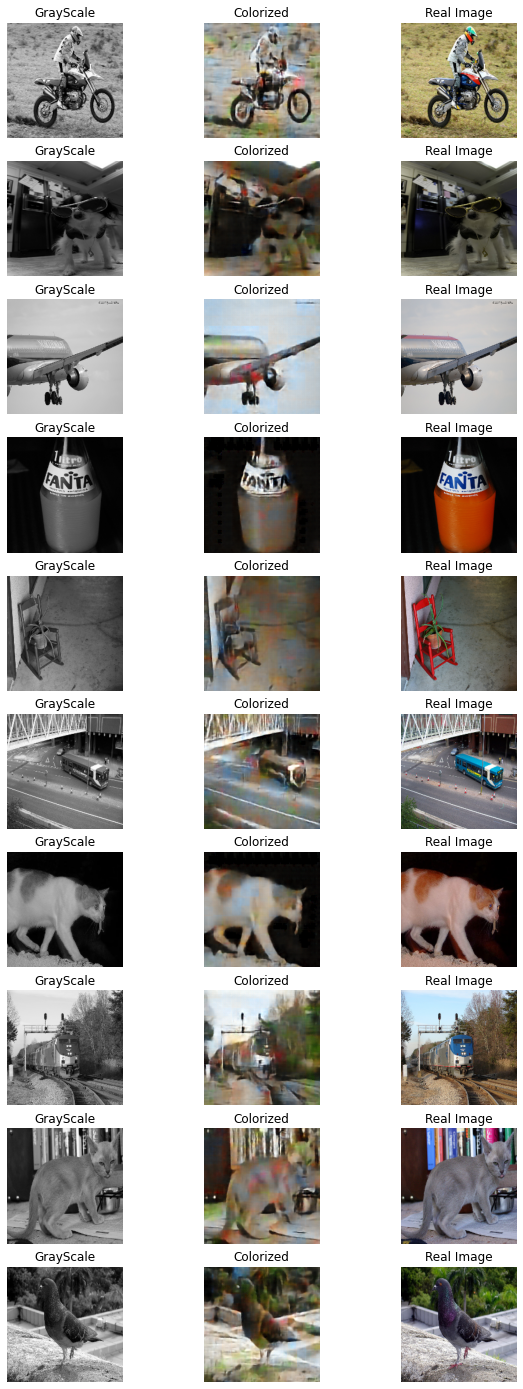

In [34]:
plt.figure(figsize=(10,25))

for i in range(1,30,3):
    rand_idx = np.random.randint(len(y_test))
    color_img = y_test[rand_idx]
    gray_img = X_test[rand_idx]
    colorized = autoencoder.predict(gray_img[np.newaxis,...])[0]

    plt.subplot(10,3,i)
    plt.title("GrayScale")
    plt.imshow(gray_img)
    plt.axis('off')
    
    plt.subplot(10,3,i+1)
    plt.title("Colorized")
    plt.imshow(colorized)
    plt.axis('off')

    plt.subplot(10,3,i+2)
    plt.title("Real Image")
    plt.imshow(color_img)
    plt.axis('off')